# Introduction

**IMAGE-BASED MULTI-FRUIT RECOGNITION AND NUTRITIONAL FACTS ESTIMATION FOR HEALTH MANAGEMENT**

**Problem Definition:**
Considering recent advancements and the spread of awareness on the impact the foods we consume have on us, more people have focused on personally improving their wellbeing by regulating and tracking what they eat. From quantities to nutrition benefits and allergen information. The importance of incorporating fruits into our diets is now well-documented as fruits provide nutrients like vitamins, minerals, iron, and calcium that help fight against and prevent several health conditions (Volpe 2019). Consuming fruits can lower the risk of chronic diseases like diabetes, hypertension, dementia and heart disease (Boeing et al. 2012). The need to monitor food consumption and eat more fruits is important to prevent these diseases and can also help people suffering from any of these conditions manage their diet better. 

Traditional methods of monitoring food consumption like journaling and manually tracking/keeping records of each food eaten and figuring out what fruit to eat with information about their nutritional value have proven tedious and highly ineffective. People find it difficult to maintain these habits in as little as a couple of days from when they start (Sahoo et al. 2019). This has birthed the emergence of tools to automate this process. Computer vision techniques (specifically deep learning methods) are the backbone of this development as they aid the accurate recognition and classification of objects in an image. A typical use case is the capturing of the image of food, or a combination of fruits and an application recognizes and classifies the image’s content, provides nutritional content and even portion estimates. These tools outperform the manual approach and have yielded effective results and steady user adoption.

## Aims and Objectives

This project aims to classify images of fruits in an image and then provide nutritional facts and health benefits/downsides related to the classified fruits. This is a multi-label classification problem as the fruits in the images are not mutually exclusive (i.e. more than one fruit can be found in an image). This problem is novel as we did not come across any single open source solution with this exact use case. Most solutions were centered around scene classifications (Mountains, beach, sunset etc.) or text classifications (document tagging, sentiment analysis).  

The following objectives were identified:

**Data Collection:**
Creating the dataset containing fruit images and collecting their corresponding nutritional facts and health information.

**Data Prepping** 
Perform data quality checks, split the data into train and validation sets for model training and performance evaluation. 

**Model Training/Selection/Performance Evaluation:**
Train different neural networks to compare and evaluate their performance on the test data to decide the best suited model. (During model evaluation and inference, validation accuracy would be the metric used to decide how good the model is)

**Evaluation of findings:**
After the model has been built, we would record our findings, limitations and recommendations while evaluating the extent to which the problem has been solved.



---



# Data Acquisition

After searching through numerous fruits image datasets to solve this multi-label classification problem, we eventually had to create our dataset. Most datasets available were designed for binary and multi-class problems where the intended classification output per image was one fruit.

For this project, we used images of multiple fruits in an image. There were also some images that had just one fruit in them. 

We purchased fruits of 12 different varieties and took a total of 407 images with a white backdrop. We ensured randomness when mixing the fruits for the images captured. The fruits used were banana, orange, apple, pear, kiwi, grape, blueberry, strawberry, raspberry, red grapes, green grapes and lemon.

These images had a JPEG compression, sRGB color represntation and 2268 x 2269 pixel dimensions. They were taken using a Samsung Galaxy A50 mobile phone.



---



We archived all folders (images, labels and health info) for this project and uploaded on google drive and used the gdown library to bring them into Colab.

In [1]:
#using the gdown library that supports download from google drive
import gdown
gdown.download('https://drive.google.com/u/0/uc?id=1TbMZtVorUeff9j-ruYVo7RC63UbocXXA&export=download', 'fruitsimages.rar', quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1TbMZtVorUeff9j-ruYVo7RC63UbocXXA&export=download
To: /content/fruitsimages.rar
100%|██████████| 725M/725M [00:07<00:00, 92.6MB/s]


'fruitsimages.rar'

In [2]:
#Extracting all folders
!unrar x '/content/fruitsimages.rar'


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/fruitsimages.rar

Creating    fruits                                                    OK
Extracting  fruits/NutFruits.csv                                           0%  OK 
Creating    fruits/test                                               OK
Extracting  fruits/test/20220417_200202.jpg                                0%  OK 
Extracting  fruits/test/20220417_200212.jpg                                0%  OK 
Extracting  fruits/test/20220417_200219.jpg                                0%  OK 
Extracting  fruits/test/20220417_200230.jpg                                0%  OK 
Extracting  fruits/test/20220417_200237.jpg                                1%  OK 
Extracting  fruits/test/20220417_200243.jpg                                1%  OK 
Extracting  fruits/test/20220417_200300.jpg                                1%  OK 
Extrac

In [ ]:
#For natural sorting in python (I used this to sort my file path outputs for getting image files)
!pip install natsort

Importing all libraries required for data exploration, visualisation, model building, training and evaluation

In [3]:
#Standard library imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import PIL
from PIL import Image
from pathlib import Path
from tqdm import tqdm, trange

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

from natsort import natsorted


In [4]:
#Using pandas to read in label and health data files
train_data = pd.read_csv('/content/fruits/train_labels.csv')
test_data = pd.read_csv('/content/fruits/test_labels.csv')
#nutrition_data = pd.read_csv('/content/fruits/NutFruits.csv', engine='python', encoding = "ISO-8859-1")

A preview of how we labelled each image in the train and test datasets and their respective sizes. 

*   1 - presence of fruit in the image
*   0 - Absence of fruit in the image


In [5]:
#Image file name and corresponding label representation
print(train_data.shape, test_data.shape)
train_data.head()

(325, 13) (82, 13)


,id,banana,orange,apple,pear,kiwi,grape,blueberry,strawberry,raspberry,red_grape,green_grape,lemon
0,20220417_145944.jpg,1,1,1,1,1,1,0,0,0,0,0,1
1,20220417_145958.jpg,1,1,1,1,1,1,0,0,0,0,0,1
2,20220417_150017.jpg,0,1,0,0,0,1,0,0,0,0,0,1
3,20220417_150031.jpg,0,1,1,1,1,0,0,0,0,0,0,1
4,20220417_150119.jpg,1,0,1,1,0,0,0,0,0,0,0,0


In [6]:
banana = '''Bananas are a healthy source of fiber, potassium, vitamin B6, vitamin C, and various antioxidants and phytonutrients.
1 medium-sized banana(100g) contains: Calories: 89, Water: 75%, Protein: 1.1 grams, Carbs: 22.8 grams, Sugar: 12.2 grams, Fiber: 2.6 grams, Fat: 0.3 grams
Bananas are a rich source of carbohydrate.
Bananas are a good source of several vitamins and minerals, especially potassium, vitamin B6, and vitamin C
Bananas are a good source of potassium. A diet high in potassium can lower blood pressure in people with elevated levels and benefits heart health.
Bananas are high in potassium, a mineral that promotes heart health and normal blood pressure. One medium-sized banana contains around 0.4 grams of this mineral.
people with diabetes should avoid eating a lot of well-ripened bananas. It’s always best to monitor blood sugar levels carefully after consuming high amounts of of sugar and carbs.
If not consumed in moderation, is a risk factor for constipation.'''

orange = '''For 1 orange (140 grams): Calories: 66, Water: 86% by weight, Protein: 1.3 grams, Carbs: 14.8 grams, Sugar: 12 grams, Fiber: 2.8 grams, Fat: 0.2 grams,
Vitamin C: 92% of the Daily Value (DV)
Folate: 9% of the DV
Calcium: 5% of the DV
Potassium: 5% of the DV
Oranges are a good source of fiber
Consuming vitamin-C-rich foods may help prevent anemia, a condition that occurs when your body lacks adequate amounts of the mineral iron.
Put simply, this bright citrus fruit is an excellent addition to a healthy diet.'''

apple = '''Medium-sized apple (100 grams): Calories: 52, Water: 86%, Protein: 0.3 grams, Carbs: 13.8 grams, Sugar: 10.4 grams, Fiber: 2.4 grams, Fat: 0.2 grams
Blood cholesterol and heart disease
Blood sugar control and type 2 diabetes
Many test-tube and animal studies suggest that apple phytonutrients can protect against cancers of the lungs and colon
Apples are healthy, tasty, and among the most popular fruits in the world.
Although they are not particularly rich in vitamins and minerals, they’re a good source of fibers and antioxidants.
Apples may have several benefits, including improved heart health and a lower risk of cancer and diabetes. They may also aid weight loss.
If you want to eat healthy, apples are an excellent choice.'''

pear = '''A medium-sized pear (178 grams) provides the following nutrients: Calories: 101, Protein: 1 gram, Carbs: 27 grams, Fiber: 6 grams, Vitamin C: 12% of the Daily Value (DV)
Vitamin K: 6% of DV
Potassium: 4% of the DV
Copper: 16% of DV
Pears are a powerhouse fruit, packing fiber, vitamins, and beneficial plant compounds.
These nutrients are thought to fight inflammation, promote gut and heart health, protect against certain diseases, and even aid weight loss.
Just be sure to eat the peel, as it harbors many of this fruit’s nutrients.'''

kiwi = '''A 3.5 ounce (100-gram) serving of green kiwi: Calories: 64, Carbs: 14 grams, Fiber: 3 grams, Fat: 0.44 grams, Protein: 1 gram 
Vitamin C: 83% of the Daily Value (DV)
Vitamin E: 9% of the DV
Vitamin K: 34% of the DV
Folate: 7% of the DV
Kiwis are a small fruit with a satisfyingly sweet taste and an impressive nutrient profile.
Not only are they packed with nutrients, like vitamins C and E, but studies show they may also benefit the health of your heart and digestive system and help you boost your intake of protective plant compounds.
Kiwis are also easy to use in the kitchen and you can enjoy them in both sweet and savory recipes.'''

grape = '''Here are some of the major nutrients found in half of a medium-sized grapefruit: Calories: 52, Carbs: 13 grams, Protein: 1 gram, Fiber: 2 grams
Vitamin C: 64% of the recommended dietary intake (RDI)
Vitamin A: 28% of the RDI
It may reduce the risk of kidney stones
Grapefruit has hydration benefits
It’s easy to add to your diet
Grapefruit has weight loss benefits'''

blueberry = '''A 3.5-ounce (100-gram) serving of raw blueberries has: Calories: 57, Water: 84%, Protein: 0.7 grams, Carbs: 14.5 grams, Sugar: 10 grams
Fiber: 2.4 grams
Fat: 0.3 grams
Good for brain and heart health
Blueberries Reduce DNA Damage, Which May Help Protect Against Aging and Cancer
Blueberries Protect Cholesterol in Your Blood From Becoming Damaged
Blueberries May Lower Blood Pressure
Blueberries May Help Prevent Heart Disease
Anthocyanins in Blueberries May Have Anti-Diabetes Effects'''

strawberry = '''Strawberries mainly consist of water (91%) and carbohydrates (7.7%). They contain only minor amounts of fat (0.3%) and protein (0.7%).
The nutrients in 3.5 ounces (100 grams) of raw strawberries are: Calories: 32, Water: 91%, Protein: 0.7 grams, Carbs: 7.7 grams
Sugar: 4.9 grams
Fiber: 2 grams
Fat: 0.3 grams
Good for heart health
Blood Sugar regulation
Cancer prevention
The health benefits include reduced cholesterol, blood pressure, inflammation, and oxidative stress.
Furthermore, these berries may help prevent big spikes in both blood sugar and insulin levels.'''

raspberry = '''One cup (123 grams) of red raspberries contains: Calories: 64, Carbs: 14.7 grams, Fiber: 8 grams, Protein: 1.5 grams, Fat: 0.8 grams
Vitamin C: 54% of the Reference Daily Intake (RDI), Manganese: 41% of the RDI, Vitamin K: 12% of the RDI, Vitamin E: 5% of the RDI
B vitamins: 4–6% of the RDI, Iron: 5% of the RDI, Magnesium: 7% of the RDI
Phosphorus: 4% of the RDI
Potassium: 5% of the RDI
Copper: 6% of the RDI
May Have Cancer-Fighting Properties
High Fiber and Tannin Content May Benefit Blood Sugar Control
Improve Arthritis
Aid weight loss
Combat aging
Raspberries are low in calories but high in fiber, vitamins, minerals and antioxidants.
They may protect against diabetes, cancer, obesity, arthritis and other conditions and may even provide anti-aging effects.
Raspberries are easy to add to your diet and make a tasty addition to breakfast, lunch, dinner or dessert.'''

red_grape = '''Grapes are high in several important nutrients. Just 1 cup (151 grams) of red or green grapes provides:
Calories: 104, Carbs: 27 grams, Protein: 1 gram, Fat: 0.2 grams, Fiber: 1.4 grams, Copper: 21% of the daily value (DV)
Vitamin K: 18% of the DV, Thiamine (vitamin B1): 9% of the DV, Riboflavin (vitamin B2): 8% of the DV, Vitamin B6: 8% of the DV
Potassium: 6% of the DV, Vitamin C: 5% of the DV, Manganese: 5% of the DV, Vitamin E: 2% of the DV
May have anticancer effects
Reduce Cholesterol
Aid heart health
May protect against diabetes and lower blood sugar levels'''

green_grape = '''Grapes are high in several important nutrients. Just 1 cup (151 grams) of red or green grapes provides: Calories: 104
Carbs: 27 grams, Protein: 1 gram, Fat: 0.2 grams, Fiber: 1.4 grams, Copper: 21% of the daily value (DV)
Vitamin K: 18% of the DV, Thiamine (vitamin B1): 9% of the DV, Riboflavin (vitamin B2): 8% of the DV, Vitamin B6: 8% of the DV
Potassium: 6% of the DV, Vitamin C: 5% of the DV, Manganese: 5% of the DV, Vitamin E: 2% of the DV
May improve memory, attention, and mood
May support bone health
May benefit skin and hair health
May have anti-obesity effects
May relieve constipation
Grapes offer several important nutrients and powerful plant compounds that benefit your health.
Antioxidants like resveratrol provide most of grapes’ benefits, including their anti-inflammatory, anti-diabetes, and anticancer properties.'''

lemon = '''Lemons contain very little fat and protein. They consist mainly of carbs (10%) and water (88–89%).
A medium lemon provides only about 20 calories.
The nutrients in 1/2 cup (100 grams) of raw, peeled lemon are: Calories: 29, Water: 89%, Protein: 1.1 grams
Carbs: 9.3 grams, Sugar: 2.5 grams, Fiber: 2.8 grams, Fat: 0.3 grams
Anemia prevention
Improve Heary Health
Lemons are a refreshing fruit usually not eaten whole but rather as a garnish or flavoring.
They are an excellent source of vitamin C, soluble fibers, and plant compounds — all of which can provide health benefits.'''

nutrition = {
   "banana": banana,
   "orange": orange,
   "apple": apple,
   "pear": pear,
   "kiwi": kiwi,
   "grape": grape,
   "blueberry": blueberry,
   "strawberry": strawberry,
   "raspberry": raspberry,
   "red_grape": red_grape,
   "green_grape": green_grape,
   "lemon": lemon
   }

The distribution of each fruit across the images in the training dataset

(banana         147
 red_grape      138
 orange         136
 lemon          126
 apple          113
 green_grape    106
 kiwi            96
 blueberry       93
 pear            92
 raspberry       79
 strawberry      65
 grape           61
 dtype: int64, <matplotlib.axes._subplots.AxesSubplot at 0x7f036784a5d0>)

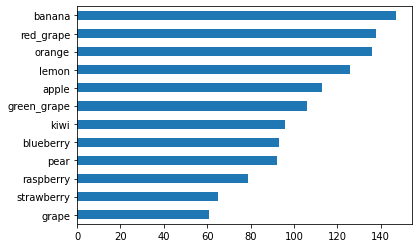

In [7]:
#Train images distribution
train_columns = train_data.columns.tolist()[1:]
train_data[train_columns].sum().sort_values(ascending=False), train_data[train_columns].sum().sort_values().plot(kind="barh")

The distribution of each fruit across the images in the validation dataset

(apple          37
 banana         35
 orange         35
 red_grape      21
 kiwi           17
 pear           16
 grape          16
 blueberry      16
 raspberry      13
 green_grape    12
 lemon          10
 strawberry      7
 dtype: int64, <matplotlib.axes._subplots.AxesSubplot at 0x7f036777ca50>)

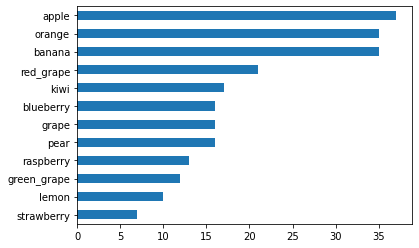

In [8]:
#Test images
test_columns = test_data.columns.tolist()[1:]
test_data[test_columns].sum().sort_values(ascending=False),test_data[test_columns].sum().sort_values().plot(kind="barh")



---



# Models

**Convolutional Neural Network Model**

Convolutional Neural Networks (CNN) are a supervised machine learning technique based on deep learning and are widely used for image classification due to their ability to handle non-linear relationships between an image attribute and its class (Murphy 2016). Supervised learning involves classifying (predicting) or identifying the class of a given input data based on previous examples. In the image classification pipeline, an image and its corresponding label are passed into a neural network and the network identifies specific attributes of that image and in turn associates it with the labelled class. 

CNNs consist of a collection of convolutions, pooling and connected layers that perform feature extraction and then classification. The convolution layer scans through an array of image pixels (1 pixel at a time) using a predefined number of filters and preserves the correlation between these pixels to observe and learn the image’s features. The outcome of this process creates a feature map. In the pooling layer, the feature map’s size is reduced using averaging or maximum techniques to reduce the parameters of the feature map and improve the processing time of the network. In the last layer, the class of the image is stored, and a mathematical representation of the image attribute is what is used for subsequent classifications. 

Our proposed problem solver implements a Convolutional Neural Network to perform feature abstraction on an image of multiple fruits and classify that image as containing multiple fruit classes. Our approach is shown in the figure below:


<img src='https://drive.google.com/uc?id=1DkS3HYQesV41tVgX1RO1r40GyqG8bV8T' width="1061" height="389.5">

**Our next steps involved:**

1. Loading the dataset and structuring it for training the neural network
2. Defining the Convolution Neural Network (CNN)
3. Defining a loss function
4. Training the model on the training data
5. Testing the model on the test data
6. Using a pretrained model on the training data
7. Testing the model
8. Comparing the perfomance of both models

# Data Processing & Preparation 
We created functions and a custom dataset class to prepare our train and test data for the CNN model.

In [9]:
def get_image_files(path):
  ''' returns images in the specified path '''
  x = [f for f in Path(path).iterdir()]
  image_list = [Path(p) for p in natsorted([str(p) for p in x])]
  return image_list


class CustomFruitsDataset(Dataset):
  '''Creating a custom dataset class that takes in the the image directory, labels file and transforms the images to tensors as a default'''
  def __init__(self, image_dir, labels_csv, transform=transforms.ToTensor()):
    super().__init__()
    self.csv = pd.read_csv(labels_csv)
    self.x = image_dir
    self.y = self.csv.drop(['id'], axis=1)
    self.transform = transform

  def __len__(self):
    '''returns the size of the dataset'''
    return len(self.y)

  def __getitem__(self, ix):
    '''this class method would return and image tensor and its corresponding label'''
    fn = self.x[ix]
    im = PIL.Image.open(fn)
    im = self.transform(im).float()
    label = torch.from_numpy(self.y.iloc[ix].values).float()
    return im, label

At this point, we specify where the images and labels are stored then call the **get_image_files function** to get the images in each directory.

In [10]:
#Directories of the train and test images
train_dir = '/content/fruits/train/'
test_dir = '/content/fruits/test/'

#Directories of the trainand test image labels
train_labels = '/content/fruits/train_labels.csv'
test_labels = '/content/fruits/test_labels.csv'

#calling the get_image_files function to collect all images in these directories
train_files = get_image_files(train_dir)
test_files = get_image_files(test_dir)

**Using augmentation techniques (Pytorch 2022a), we doubled our dataset by applying transforms and then concatenating the original dataset with the transformed dataset.**

**Transforms applied on the original training dataset:**

* torchvision.transforms.ReSize((256,256)) - Resizes the input image to the specified size (256 width, 256 height).
* torchvision.transforms.ToTensor() - Converts the given PIL Image to tensor.
* torchvision.transforms.Normalize(mean, std) - This is done to normalize a tensor image with its mean and standard deviation (which are calculated by getting the mean and standard deviation across each channel). 


**Transforms applied on the training dataset used to add data:**

* torchvision.transforms.ReSize((256,256))
* torchvision.transforms.RandomHorizontalFlip(p=0.9) - Horizontally flip the given image randomly with a given probability. 0.9 in this case maeans the image would get flipped 9 out of 10 times.
* torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2) - This adjusts the sharpness of the image
* torchvision.transforms.ColorJitter(brightness=(0.8, 1.5), contrast=(0.8,1.5)) - Randomly changes the brightness and contrast of an image within the specified range.
* torchvision.transforms.RandomPerspective(distortion_scale=0.4, p=0.3, fill=(255,255,255)) - This performs a random perspective transformation of the given image with a given probability.
* torchvision.transforms.ToTensor()
* torchvision.transforms.Normalize(mean, std)

**Transforms applied on the original test dataset:**

* torchvision.transforms.ReSize((256,256))
* torchvision.transforms.CenterCrop((224,224)) - Crops the given image at the center using the specified dimensions. 
* torchvision.transforms.ToTensor()
* torchvision.transforms.Normalize(mean, std)




---



**Calculating the mean and standard deviation of each channel in the images:**

In [11]:
X = []

for i in tqdm(range(len(train_data))):
    path = train_dir + train_data['id'][i]
    img = Image.open(path).resize((256,256))
    img = np.array(img)
    img = img/255
    
    X.append(img)

X = np.asarray(X)
mean = np.mean(X, axis=(0,1,2))
std = np.std(X, axis=(0,1,2))
X_norm  = (X - np.mean(X)) / np.std(X)
X_norm.mean(), X_norm.std(), mean, std

100%|██████████| 325/325 [01:01<00:00,  5.31it/s]


(-6.786964153075832e-15,
 1.000000000000001,
 array([0.57948554, 0.52986705, 0.47784213]),
 array([0.19533188, 0.22711439, 0.25292398]))

In [11]:
mean = [0.57948554, 0.52986705, 0.47784213]
std = [0.19533188, 0.22711439, 0.25292398]
norms = (mean, std)

#creating custom transforms on the train and test images
train_transform = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(*norms)])


train_transform_1 = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.RandomHorizontalFlip(p=0.8),
                                        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.8),
                                        transforms.ColorJitter(brightness=(0.8, 1.5), contrast=(0.8,1.5)),
                                        transforms.RandomPerspective(distortion_scale=0.4, p=0.3, fill=(255,255,255)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(*norms)])

test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(*norms)])


#calling the custom dataset class to create our train and test datasets with their labels and tranformations applied

#Train
train_dataset = CustomFruitsDataset(train_files, train_labels, train_transform)
train_dataset_1 = CustomFruitsDataset(train_files, train_labels, train_transform_1)

#Test
test_dataset = CustomFruitsDataset(test_files, test_labels, test_transform)

#Concatenating both training datasets
add_train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_1])

In [12]:
# The size of the train and test dataload
print('Training set has {} instances'.format(len(add_train_dataset)))
print('Test set has {} instances'.format(len(test_dataset)))

Training set has 650 instances
Test set has 82 instances


We created functions to normalize and return samples of images in the train and test datasets

In [13]:
def inverse_normalize(tensor, mean = mean, std =std):
  '''Returns the inverse of a normalized tensor'''
  for t, m, s in zip(tensor, mean, std):
    t.mul_(s).add_(m)
  return tensor

def showim(img):
  '''Takes in an image tensor from the dataset and displays'''
  plt.imshow(inverse_normalize(img).permute(1, 2, 0))
  plt.show()

We also created functions to return the real life labels (fruit names) of an image and also their corresponding nutritional facts and health tips

In [14]:
classes = list(train_data.columns[1:])

def hot2label(tensorlabel):
  '''Returns the real labels of the encoded tensor label '''
  lab = []
  for i in range(len(tensorlabel)):
    if tensorlabel[i] == 1: lab.append(classes[i])
  return lab

def showim_label(input):
  '''Returns an image and its real label'''
  im = plt.imshow(inverse_normalize(input[0]).permute(1, 2, 0))
  _lab = hot2label(input[1])

  return im, _lab

def infer_usecase(output):
  '''Returns the label and nutrition/health information of a predicted output'''
  label, nutri = [], []
  
  for i in range(len(output)):
    if output[i] == 1: label.append(classes[i])

  for i in range(len(label)):
    if label[i] in classes:
      nutri.append(nutrition[label[i]])
  

  return label, nutri

Using the pytorch dataloader class (torch.utils.data.DataLoader), we set the number of training examples the model would use in one iteration and shuffled the training set to allow the model generalise better in the learning phase

In [15]:
batch_size = 32
train_loader = DataLoader(add_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Data Visualization
Visualising a random batch of images in the training dataset

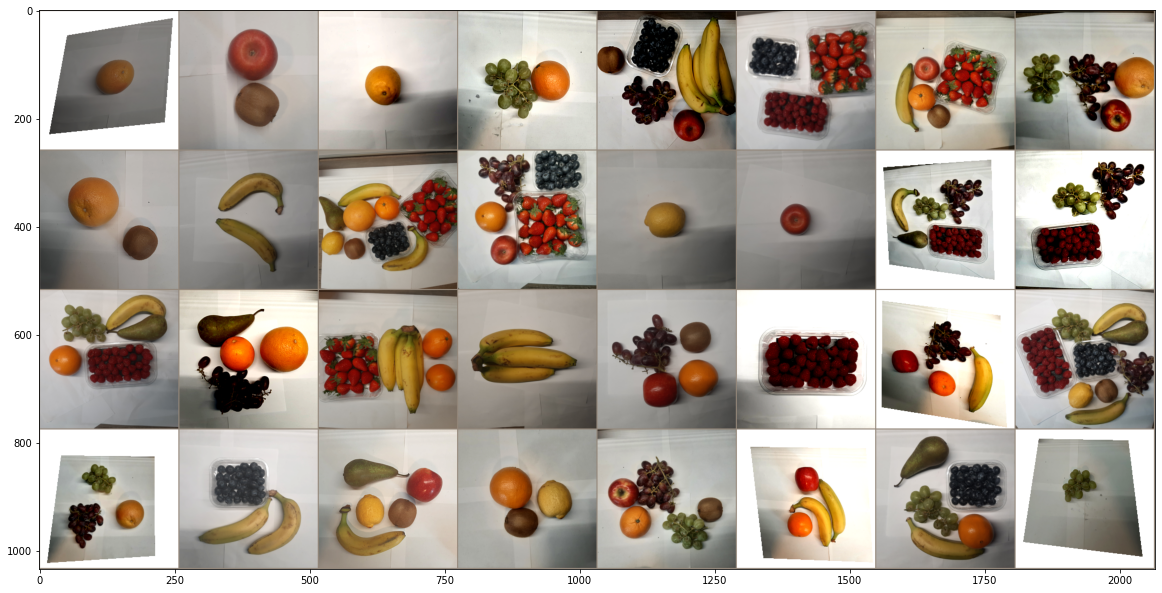

In [16]:
# random training images
train_batch = iter(train_loader)
images, labels = train_batch.next()

# show images
plt.figure(figsize=(20,14))
showim(torchvision.utils.make_grid(images))

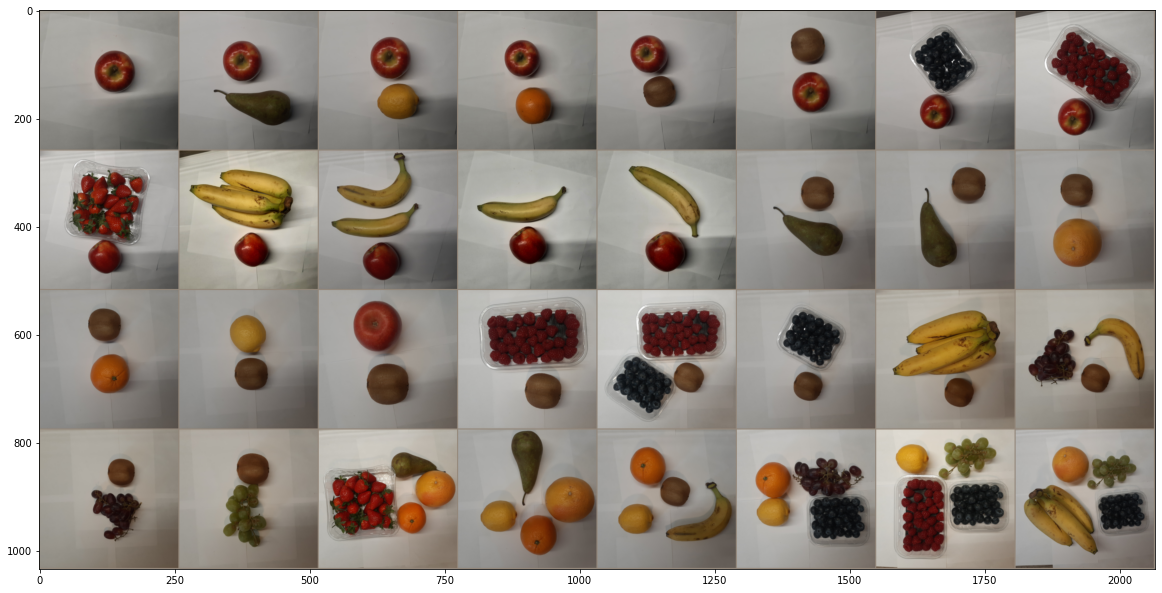

In [32]:
# random testing images
test_batch = iter(validation_loader)
images, labels = test_batch.next()

# show images
plt.figure(figsize=(20,14))
showim(torchvision.utils.make_grid(images))

Image and Labels of sample train and test images

(<matplotlib.image.AxesImage at 0x7f036187c890>,
 ['banana', 'orange', 'apple', 'pear', 'kiwi', 'grape', 'lemon'])

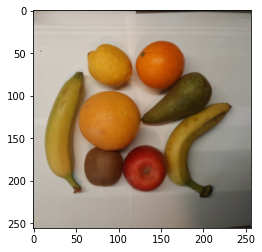

In [17]:
#Train
showim_label(train_dataset[0])

(<matplotlib.image.AxesImage at 0x7f03617ecc10>, ['apple', 'lemon'])

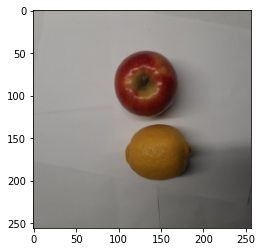

In [18]:
#Test
showim_label(test_dataset[2])

# Convolution Neural Network (CNN)

Our CNN is structured with the following 16 layers:

Conv - MaxPool - LeakyReLU - Conv - MaxPool - LeakyReLU - Conv - MaxPool - LeakyReLU - Conv - MaxPool - LeakyReLU - Linear - Linear - Linear - Sigmoid

A sigmoid activation function is used in our network to handle the non mutually exclusive nature of the multi-label fruit classification problem.

#### Network

In [25]:
class FruitClassifier(nn.Module):
    def __init__(self):
        super(FruitClassifier, self).__init__()

        self.conv_stack = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3),
                nn.LeakyReLU(),
                nn.MaxPool2d(2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                nn.LeakyReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
                nn.LeakyReLU(),
                nn.MaxPool2d(2),
                
                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
                nn.LeakyReLU(),
                nn.MaxPool2d(2)               
                )

        self.Linear1 = nn.Linear(512 * 14 * 14, 1024)
        self.Linear2 = nn.Linear(1024, 256)
        self.Linear3 = nn.Linear(256, 12)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, x):
        x = self.conv_stack(x)
        x = nn.Flatten(x)
        x = self.Linear1(x)
        x = self.Linear2(x)
        x = self.Linear3(x)
        return self.sigmoid(x)

#### Model Initialisation

Since we are going to be using the free GPU provided by Colab for computation, we initialised a variable to store the cuda gpu provided and initialised and set our model to the device

In [26]:
# setting device based on what runtime is used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Model initialization to GPU
model = FruitClassifier().to(device)

#### Hyperparameters

We defined the hyperparameters our model would be optimized with:

A learning rate of 0.001 which is the default for the Adam optimizer was used and this proved to be the best value after training the model for maximum validation accuracy.

*The learning rate determines the learning speed (how much the models parameters get updated after each epoch) of the model during training.* (Pytorch 2022b)

The BCELoss function which calculates the binary cross entropy between the predicted probabilities (numbers between 0 and 1) and the one hot encoded label was used as our network makes use of a sigmoid in its last layer. Lastly, the Adam optimizer algorithm was used to modify the attributes of our network during training (Pytorch 2022b). It proved to be the best in reducing the model's overall loss and improving its accuracy over time.

In [27]:
learning_rate = 0.001
lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Multi-label Accuracy Function

To calulate the accuracy of our model's prediction, we created a function to round the predicted sigmoid outputs at a default threshold of 0.5 and compare the accuracy with the original encoded label.

In [24]:
#Sample of accuracy in action

tens1 = torch.tensor([1,0,1,1,0,1,0,1,1,0,0,0]) #sample label after rounding the sigmoid output
tens2 = torch.tensor([1,0,1,1,0,1,0,1,1,1,0,0]) #original encoded fruit label

# Note: Only one incorrect prediction at index position 9

x = tens1.eq(tens2)
print(x)

print(x.sum())

print(x.sum()/len(tens2))

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True, False,
         True,  True])
tensor(11)
tensor(0.9167)


In [22]:
def accuracy(original, predicted):
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

#### Training/Optimization and Validation Function

We created a function to perform both training and validation based on the phase argument passed when calling the function.

The number of epochs, model to train, the dataloader to iterate over and phase (training or validation) are the arguments that must be passed

* In the training phase, the model iterates over the training data loader and optimizes its paramters after each epoch.

* In the validation phase, the model iterates over the test data loader and calculates the accuracy (using our defined accuracy function) to test and improve the model.

The total loss and accuracy values are also appended to a list to evluate the model after each epoch.

In [23]:
def fit_model(epochs, model, dataloader, phase = 'training'):
    
    print(f'Epoch: {epochs}')

    if phase == 'training':
        model.train()
        
    if phase == 'validation':
        model.eval()
        
    running_loss = []
    running_acc = []

    count = 0
    for i, (images, labels) in tqdm(enumerate(dataloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        if phase == 'training':
            optimizer.zero_grad()
            
        outputs = model(images)
        
        acc_ = []
        for i, d in enumerate(outputs, 0):
           
            acc = accuracy(torch.Tensor.cpu(labels[i]), torch.Tensor.cpu(d))
            acc_.append(acc)

        loss = lossfunc(outputs, labels)
                
        running_loss.append(loss.item())
        running_acc.append(np.asarray(acc_).mean())

        count += 1
       
        if phase == 'training':
            
            loss.backward()
        
            optimizer.step()
            
    total_batch_loss = np.asarray(running_loss).mean()
    total_batch_acc = np.asarray(running_acc).mean()
    

    print(f'{phase} loss is {total_batch_loss}')
    print(f'{phase} accuracy is {total_batch_acc}')
    
    return total_batch_loss, total_batch_acc

#### Training/Optimization and Validation Loop

We trained the model and iterate over the train and test dataloaders 30 times (30 epochs) to optimize and evaluate the model's performance.

In [28]:
trn_losses, val_losses = [], [] 
trn_acc, val_acc = [], []
for i in tqdm(range(1, 17)):
    trn_l, trn_a = fit_model(i, model, train_loader, phase= 'training')
    val_l, val_a = fit_model(i, model, validation_loader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1



0it [00:00, ?it/s]
1it [00:10, 10.38s/it]
2it [00:10,  4.55s/it]
3it [00:20,  7.04s/it]
4it [00:21,  4.46s/it]
5it [00:30,  6.19s/it]
6it [00:31,  4.23s/it]
7it [00:40,  5.85s/it]
8it [00:40,  4.13s/it]
9it [00:50,  5.83s/it]
10it [00:50,  4.16s/it]
11it [01:01,  6.10s/it]
12it [01:01,  4.39s/it]
13it [01:10,  5.88s/it]
14it [01:11,  4.24s/it]
15it [01:20,  5.73s/it]
16it [01:21,  4.19s/it]
17it [01:30,  5.66s/it]
18it [01:30,  4.09s/it]
19it [01:40,  5.68s/it]
20it [01:40,  4.10s/it]
21it [01:42,  4.86s/it]

training loss is 0.9728738041151137
training accuracy is 0.6252728174603176
Epoch: 1




0it [00:00, ?it/s]
1it [00:09,  9.80s/it]
2it [00:10,  4.19s/it]
3it [00:13,  4.41s/it]
  6%|▋         | 1/16 [01:55<28:52, 115.53s/it]

validation loss is 0.5495814482371012
validation accuracy is 0.7534722222222223
Epoch: 2



0it [00:00, ?it/s]
1it [00:09,  9.96s/it]
2it [00:10,  4.37s/it]
3it [00:20,  6.81s/it]
4it [00:20,  4.30s/it]
5it [00:30,  6.18s/it]
6it [00:30,  4.24s/it]
7it [00:40,  5.98s/it]
8it [00:40,  4.28s/it]
9it [00:50,  5.83s/it]
10it [00:50,  4.29s/it]
11it [00:59,  5.67s/it]
12it [01:00,  4.16s/it]
13it [01:09,  5.63s/it]
14it [01:10,  4.15s/it]
15it [01:19,  5.70s/it]
16it [01:20,  4.21s/it]
17it [01:32,  6.56s/it]
18it [01:34,  5.15s/it]
19it [01:45,  7.04s/it]
20it [01:46,  5.24s/it]
21it [01:47,  5.13s/it]

training loss is 0.5628293809436616
training accuracy is 0.7083581349206349
Epoch: 2




0it [00:00, ?it/s]
1it [00:09,  9.94s/it]
2it [00:10,  4.17s/it]
3it [00:13,  4.42s/it]
 12%|█▎        | 2/16 [03:56<27:44, 118.87s/it]

validation loss is 0.5208395520846049
validation accuracy is 0.7521219135802469
Epoch: 3



0it [00:00, ?it/s]
1it [00:09,  9.78s/it]
2it [00:10,  4.32s/it]
3it [00:19,  6.63s/it]
4it [00:20,  4.19s/it]
5it [00:29,  6.08s/it]
6it [00:29,  4.16s/it]
7it [00:39,  5.95s/it]
8it [00:40,  4.19s/it]
9it [00:49,  5.75s/it]
10it [00:49,  4.13s/it]
11it [00:59,  5.75s/it]
12it [00:59,  4.16s/it]
13it [01:08,  5.71s/it]
14it [01:09,  4.14s/it]
15it [01:18,  5.70s/it]
16it [01:19,  4.19s/it]
17it [01:28,  5.57s/it]
18it [01:29,  4.18s/it]
19it [01:38,  5.64s/it]
20it [01:38,  4.17s/it]
21it [01:40,  4.78s/it]

training loss is 0.5173663596312205
training accuracy is 0.7412946428571429
Epoch: 3




0it [00:00, ?it/s]
1it [00:09,  9.86s/it]
2it [00:10,  4.16s/it]
3it [00:13,  4.43s/it]
 19%|█▉        | 3/16 [05:50<25:15, 116.56s/it]

validation loss is 0.5387102961540222
validation accuracy is 0.7280092592592592
Epoch: 4



0it [00:00, ?it/s]
1it [00:09,  9.92s/it]
2it [00:10,  4.37s/it]
3it [00:19,  6.54s/it]
4it [00:19,  4.13s/it]
5it [00:29,  5.99s/it]
6it [00:29,  4.10s/it]
7it [00:39,  5.87s/it]
8it [00:39,  4.15s/it]
9it [00:49,  5.85s/it]
10it [00:49,  4.18s/it]
11it [00:59,  5.78s/it]
12it [00:59,  4.15s/it]
13it [01:08,  5.71s/it]
14it [01:09,  4.12s/it]
15it [01:18,  5.64s/it]
16it [01:18,  4.08s/it]
17it [01:28,  5.64s/it]
18it [01:28,  4.09s/it]
19it [01:38,  5.70s/it]
20it [01:38,  4.11s/it]
21it [01:40,  4.77s/it]

training loss is 0.46981150053796317
training accuracy is 0.7702628968253968
Epoch: 4




0it [00:00, ?it/s]
1it [00:09,  9.81s/it]
2it [00:09,  4.11s/it]
3it [00:13,  4.39s/it]
 25%|██▌       | 4/16 [07:44<23:04, 115.36s/it]

validation loss is 0.5732183555761973
validation accuracy is 0.6890432098765432
Epoch: 5



0it [00:00, ?it/s]
1it [00:10, 10.06s/it]
2it [00:10,  4.40s/it]
3it [00:19,  6.68s/it]
4it [00:20,  4.24s/it]
5it [00:29,  6.03s/it]
6it [00:30,  4.13s/it]
7it [00:39,  5.83s/it]
8it [00:39,  4.11s/it]
9it [00:49,  5.75s/it]
10it [00:49,  4.11s/it]
11it [00:59,  5.75s/it]
12it [00:59,  4.15s/it]
13it [01:08,  5.71s/it]
14it [01:09,  4.12s/it]
15it [01:18,  5.75s/it]
16it [01:19,  4.14s/it]
17it [01:28,  5.67s/it]
18it [01:28,  4.10s/it]
19it [01:38,  5.75s/it]
20it [01:38,  4.15s/it]
21it [01:40,  4.79s/it]

training loss is 0.4549384145509629
training accuracy is 0.7826884920634921
Epoch: 5




0it [00:00, ?it/s]
1it [00:10, 10.00s/it]
2it [00:10,  4.21s/it]
3it [00:13,  4.49s/it]
 31%|███▏      | 5/16 [09:38<21:04, 114.94s/it]

validation loss is 0.5149082541465759
validation accuracy is 0.746045524691358
Epoch: 6



0it [00:00, ?it/s]
1it [00:09,  9.52s/it]
2it [00:10,  4.24s/it]
3it [00:19,  6.49s/it]
4it [00:19,  4.19s/it]
5it [00:29,  6.05s/it]
6it [00:29,  4.14s/it]
7it [00:39,  5.86s/it]
8it [00:39,  4.15s/it]
9it [00:48,  5.74s/it]
10it [00:49,  4.13s/it]
11it [00:58,  5.71s/it]
12it [00:59,  4.18s/it]
13it [01:08,  5.67s/it]
14it [01:09,  4.16s/it]
15it [01:17,  5.56s/it]
16it [01:18,  4.15s/it]
17it [01:27,  5.59s/it]
18it [01:28,  4.08s/it]
19it [01:37,  5.69s/it]
20it [01:38,  4.15s/it]
21it [01:39,  4.75s/it]

training loss is 0.43102637784821646
training accuracy is 0.8023809523809524
Epoch: 6




0it [00:00, ?it/s]
1it [00:09,  9.99s/it]
2it [00:10,  4.19s/it]
3it [00:13,  4.45s/it]
 38%|███▊      | 6/16 [11:31<19:04, 114.40s/it]

validation loss is 0.5498907069365183
validation accuracy is 0.7371720679012346
Epoch: 7



0it [00:00, ?it/s]
1it [00:09,  9.93s/it]
2it [00:10,  4.34s/it]
3it [00:20,  6.84s/it]
4it [00:20,  4.33s/it]
5it [00:30,  6.15s/it]
6it [00:30,  4.21s/it]
7it [00:39,  5.94s/it]
8it [00:40,  4.18s/it]
9it [00:50,  5.89s/it]
10it [00:50,  4.20s/it]
11it [01:00,  5.89s/it]
12it [01:00,  4.23s/it]
13it [01:09,  5.78s/it]
14it [01:10,  4.18s/it]
15it [01:19,  5.77s/it]
16it [01:20,  4.16s/it]
17it [01:29,  5.71s/it]
18it [01:30,  4.12s/it]
19it [01:39,  5.69s/it]
20it [01:39,  4.11s/it]
21it [01:41,  4.84s/it]

training loss is 0.40393988433338346
training accuracy is 0.8136904761904761
Epoch: 7




0it [00:00, ?it/s]
1it [00:09,  9.99s/it]
2it [00:10,  4.20s/it]
3it [00:13,  4.45s/it]
 44%|████▍     | 7/16 [13:26<17:11, 114.62s/it]

validation loss is 0.5595293243726095
validation accuracy is 0.7430555555555557
Epoch: 8



0it [00:00, ?it/s]
1it [00:10, 10.00s/it]
2it [00:10,  4.38s/it]
3it [00:19,  6.68s/it]
4it [00:20,  4.21s/it]
5it [00:29,  6.13s/it]
6it [00:30,  4.19s/it]
7it [00:39,  5.89s/it]
8it [00:40,  4.15s/it]
9it [00:49,  5.82s/it]
10it [00:50,  4.17s/it]
11it [00:59,  5.70s/it]
12it [00:59,  4.10s/it]
13it [01:09,  5.73s/it]
14it [01:09,  4.13s/it]
15it [01:19,  5.78s/it]
16it [01:19,  4.17s/it]
17it [01:29,  5.83s/it]
18it [01:29,  4.22s/it]
19it [01:39,  5.77s/it]
20it [01:39,  4.17s/it]
21it [01:41,  4.82s/it]

training loss is 0.3723619963441576
training accuracy is 0.8315972222222223
Epoch: 8




0it [00:00, ?it/s]
1it [00:09,  9.90s/it]
2it [00:10,  4.18s/it]
3it [00:13,  4.45s/it]
 50%|█████     | 8/16 [15:21<15:17, 114.66s/it]

validation loss is 0.5686827600002289
validation accuracy is 0.7324459876543209
Epoch: 9



0it [00:00, ?it/s]
1it [00:09,  9.51s/it]
2it [00:10,  4.25s/it]
3it [00:19,  6.54s/it]
4it [00:19,  4.15s/it]
5it [00:29,  5.97s/it]
6it [00:29,  4.09s/it]
7it [00:38,  5.85s/it]
8it [00:39,  4.13s/it]
9it [00:48,  5.74s/it]
10it [00:49,  4.10s/it]
11it [00:58,  5.75s/it]
12it [00:59,  4.13s/it]
13it [01:08,  5.86s/it]
14it [01:09,  4.24s/it]
15it [01:18,  5.81s/it]
16it [01:19,  4.19s/it]
17it [01:28,  5.72s/it]
18it [01:28,  4.13s/it]
19it [01:38,  5.87s/it]
20it [01:39,  4.24s/it]
21it [01:40,  4.80s/it]

training loss is 0.3379897759074256
training accuracy is 0.8457589285714284
Epoch: 9




0it [00:00, ?it/s]
1it [00:10, 10.07s/it]
2it [00:10,  4.23s/it]
3it [00:13,  4.52s/it]
 56%|█████▋    | 9/16 [17:16<13:22, 114.65s/it]

validation loss is 0.4863107005755107
validation accuracy is 0.7797067901234568
Epoch: 10



0it [00:00, ?it/s]
1it [00:10, 10.45s/it]
2it [00:10,  4.59s/it]
3it [00:21,  7.10s/it]
4it [00:21,  4.46s/it]
5it [00:31,  6.41s/it]
6it [00:31,  4.38s/it]
7it [00:41,  6.10s/it]
8it [00:41,  4.29s/it]
9it [00:51,  5.85s/it]
10it [00:51,  4.20s/it]
11it [01:01,  5.90s/it]
12it [01:01,  4.23s/it]
13it [01:11,  5.94s/it]
14it [01:12,  4.28s/it]
15it [01:21,  5.93s/it]
16it [01:22,  4.27s/it]
17it [01:32,  5.96s/it]
18it [01:32,  4.29s/it]
19it [01:41,  5.80s/it]
20it [01:42,  4.21s/it]
21it [01:43,  4.95s/it]

training loss is 0.3374171895640237
training accuracy is 0.8489583333333335
Epoch: 10




0it [00:00, ?it/s]
1it [00:09,  9.99s/it]
2it [00:10,  4.20s/it]
3it [00:13,  4.49s/it]
 62%|██████▎   | 10/16 [19:13<11:33, 115.56s/it]

validation loss is 0.5077957312266032
validation accuracy is 0.7613811728395062
Epoch: 11



0it [00:00, ?it/s]
1it [00:09,  9.78s/it]
2it [00:10,  4.29s/it]
3it [00:19,  6.73s/it]
4it [00:20,  4.24s/it]
5it [00:29,  6.13s/it]
6it [00:30,  4.22s/it]
7it [00:39,  5.99s/it]
8it [00:40,  4.22s/it]
9it [00:50,  5.92s/it]
10it [00:50,  4.23s/it]
11it [01:00,  5.92s/it]
12it [01:00,  4.25s/it]
13it [01:10,  5.83s/it]
14it [01:10,  4.22s/it]
15it [01:19,  5.77s/it]
16it [01:20,  4.16s/it]
17it [01:29,  5.76s/it]
18it [01:30,  4.15s/it]
19it [01:39,  5.65s/it]
20it [01:40,  4.23s/it]
21it [01:41,  4.84s/it]

training loss is 0.29215349895613535
training accuracy is 0.8756200396825397
Epoch: 11




0it [00:00, ?it/s]
1it [00:09,  9.96s/it]
2it [00:10,  4.18s/it]
3it [00:13,  4.47s/it]
 69%|██████▉   | 11/16 [21:08<09:37, 115.49s/it]

validation loss is 0.578181525071462
validation accuracy is 0.7615740740740741
Epoch: 12



0it [00:00, ?it/s]
1it [00:10, 10.25s/it]
2it [00:10,  4.51s/it]
3it [00:20,  6.74s/it]
4it [00:20,  4.25s/it]
5it [00:29,  6.00s/it]
6it [00:30,  4.11s/it]
7it [00:39,  5.83s/it]
8it [00:39,  4.11s/it]
9it [00:49,  5.76s/it]
10it [00:49,  4.14s/it]
11it [00:59,  5.72s/it]
12it [00:59,  4.13s/it]
13it [01:08,  5.69s/it]
14it [01:09,  4.13s/it]
15it [01:18,  5.67s/it]
16it [01:19,  4.09s/it]
17it [01:28,  5.67s/it]
18it [01:28,  4.13s/it]
19it [01:38,  5.63s/it]
20it [01:38,  4.08s/it]
21it [01:40,  4.77s/it]

training loss is 0.26092683701288133
training accuracy is 0.8901041666666666
Epoch: 12




0it [00:00, ?it/s]
1it [00:09,  9.81s/it]
2it [00:09,  4.12s/it]
3it [00:13,  4.40s/it]
 75%|███████▌  | 12/16 [23:02<07:39, 114.89s/it]

validation loss is 0.6349702974160513
validation accuracy is 0.757908950617284
Epoch: 13



0it [00:00, ?it/s]
1it [00:09,  9.81s/it]
2it [00:10,  4.29s/it]
3it [00:19,  6.64s/it]
4it [00:20,  4.19s/it]
5it [00:29,  6.02s/it]
6it [00:29,  4.14s/it]
7it [00:39,  5.79s/it]
8it [00:39,  4.08s/it]
9it [00:49,  5.81s/it]
10it [00:49,  4.15s/it]
11it [00:58,  5.72s/it]
12it [00:59,  4.11s/it]
13it [01:08,  5.71s/it]
14it [01:09,  4.11s/it]
15it [01:18,  5.71s/it]
16it [01:18,  4.14s/it]
17it [01:28,  5.69s/it]
18it [01:28,  4.13s/it]
19it [01:38,  5.68s/it]
20it [01:38,  4.19s/it]
21it [01:40,  4.77s/it]

training loss is 0.24974605086303892
training accuracy is 0.8943204365079366
Epoch: 13




0it [00:00, ?it/s]
1it [00:10, 10.03s/it]
2it [00:10,  4.20s/it]
3it [00:13,  4.47s/it]
 81%|████████▏ | 13/16 [24:56<05:43, 114.56s/it]

validation loss is 0.6480429967244467
validation accuracy is 0.7558834876543209
Epoch: 14



0it [00:00, ?it/s]
1it [00:10, 10.04s/it]
2it [00:10,  4.42s/it]
3it [00:19,  6.71s/it]
4it [00:20,  4.23s/it]
5it [00:29,  6.09s/it]
6it [00:30,  4.22s/it]
7it [00:39,  5.83s/it]
8it [00:40,  4.21s/it]
9it [00:49,  5.71s/it]
10it [00:50,  4.18s/it]
11it [00:59,  5.73s/it]
12it [01:00,  4.25s/it]
13it [01:09,  5.76s/it]
14it [01:10,  4.34s/it]
15it [01:18,  5.58s/it]
16it [01:20,  4.34s/it]
17it [01:28,  5.46s/it]
18it [01:29,  4.25s/it]
19it [01:38,  5.50s/it]
20it [01:40,  4.43s/it]
21it [01:40,  4.80s/it]

training loss is 0.22748019865580968
training accuracy is 0.9060267857142856
Epoch: 14




0it [00:00, ?it/s]
1it [00:09,  9.98s/it]
2it [00:10,  4.18s/it]
3it [00:13,  4.46s/it]
 88%|████████▊ | 14/16 [26:50<03:49, 114.53s/it]

validation loss is 0.7738472819328308
validation accuracy is 0.7519290123456791
Epoch: 15



0it [00:00, ?it/s]
1it [00:09,  9.67s/it]
2it [00:10,  4.23s/it]
3it [00:19,  6.69s/it]
4it [00:20,  4.23s/it]
5it [00:29,  6.22s/it]
6it [00:30,  4.27s/it]
7it [00:39,  6.01s/it]
8it [00:40,  4.23s/it]
9it [00:50,  5.94s/it]
10it [00:50,  4.24s/it]
11it [01:00,  5.92s/it]
12it [01:00,  4.25s/it]
13it [01:09,  5.75s/it]
14it [01:10,  4.15s/it]
15it [01:19,  5.64s/it]
16it [01:19,  4.09s/it]
17it [01:29,  5.60s/it]
18it [01:29,  4.04s/it]
19it [01:38,  5.59s/it]
20it [01:39,  4.03s/it]
21it [01:40,  4.79s/it]

training loss is 0.21693907323337736
training accuracy is 0.9132688492063492
Epoch: 15




0it [00:00, ?it/s]
1it [00:10, 10.20s/it]
2it [00:10,  4.28s/it]
3it [00:13,  4.54s/it]
 94%|█████████▍| 15/16 [28:45<01:54, 114.52s/it]

validation loss is 0.6607548793156942
validation accuracy is 0.7566550925925926
Epoch: 16



0it [00:00, ?it/s]
1it [00:09,  9.93s/it]
2it [00:10,  4.38s/it]
3it [00:19,  6.60s/it]
4it [00:20,  4.17s/it]
5it [00:29,  6.13s/it]
6it [00:30,  4.19s/it]
7it [00:39,  5.94s/it]
8it [00:40,  4.19s/it]
9it [00:49,  5.83s/it]
10it [00:49,  4.16s/it]
11it [00:59,  5.66s/it]
12it [00:59,  4.08s/it]
13it [01:09,  5.78s/it]
14it [01:09,  4.17s/it]
15it [01:19,  5.82s/it]
16it [01:19,  4.19s/it]
17it [01:29,  5.78s/it]
18it [01:29,  4.18s/it]
19it [01:38,  5.70s/it]
20it [01:39,  4.12s/it]
21it [01:40,  4.81s/it]

training loss is 0.19064689392135256
training accuracy is 0.9219494047619049
Epoch: 16




0it [00:00, ?it/s]
1it [00:10, 10.15s/it]
2it [00:10,  4.27s/it]
3it [00:13,  4.51s/it]
100%|██████████| 16/16 [30:39<00:00, 114.99s/it]

validation loss is 0.6982788840929667
validation accuracy is 0.7749807098765431


#### Visualising Model Accuracy and Loss

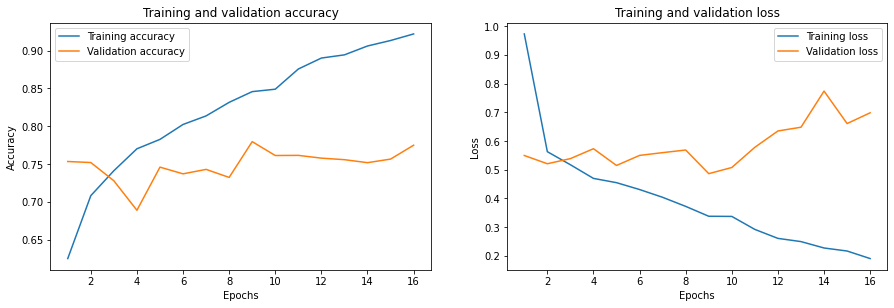

In [30]:
def graphs(train_accuracy, validation_accuracy, train_losses, validation_losses):
  # Plot the training/validation accuracy
  plt.figure(figsize=(15, 10))
  plt.subplot(2, 2, 1)
  plt.plot(range(1,17), train_accuracy, label = 'Training accuracy')
  plt.plot(range(1,17), validation_accuracy, label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(2, 2, 2)
  # Plot the training/validation accuracy
  plt.plot(range(1,17), train_losses, label = 'Training loss')
  plt.plot(range(1,17), validation_losses, label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

graphs(trn_acc, val_acc, trn_losses, val_losses)

#### Inference

A function that generates a batch of images from the validation loader and displays the models label prediction of those images.

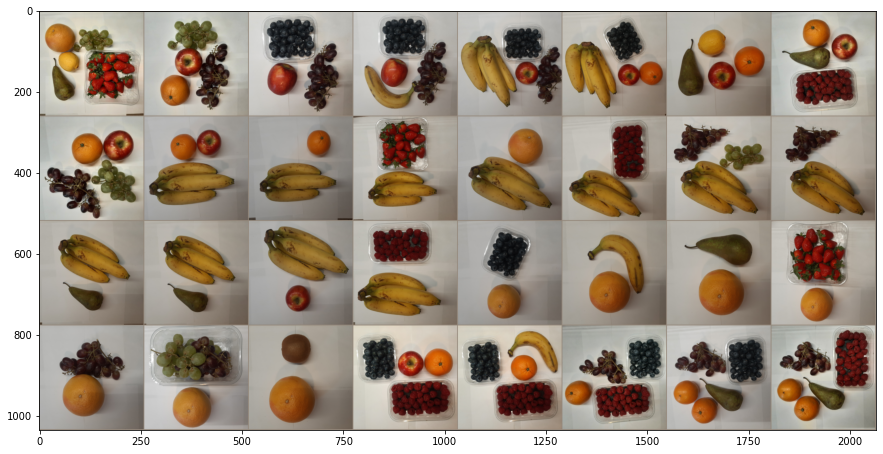

In [37]:
def infer(test_model, img):
  pred = []
  img = img.to(device)
  output = test_model(img)
  output = output.round()

  for i in output:
    pred.append(hot2label(i))

  label_list = [l for l in pred]
  return label_list

#test_batch = iter(validation_loader)
#images, labels = test_batch.next()

plt.figure(figsize=(15, 10))
inf_images, inf_labels = next(test_batch)
showim(torchvision.utils.make_grid(inf_images))

In [38]:
infer(test_model = model, img=inf_images)

[['orange', 'apple', 'kiwi', 'grape', 'green_grape'],
 ['orange', 'red_grape', 'green_grape'],
 ['orange', 'apple', 'blueberry', 'strawberry'],
 ['apple', 'kiwi', 'blueberry', 'strawberry'],
 ['banana', 'apple', 'kiwi', 'blueberry', 'lemon'],
 ['banana', 'orange', 'apple', 'kiwi', 'blueberry', 'lemon'],
 ['orange', 'grape', 'lemon'],
 ['pear', 'grape', 'raspberry'],
 ['grape', 'red_grape', 'lemon'],
 ['banana', 'apple', 'grape', 'lemon'],
 ['banana', 'kiwi', 'grape', 'lemon'],
 ['banana'],
 ['banana', 'kiwi', 'grape', 'lemon'],
 ['banana', 'apple'],
 ['banana', 'lemon'],
 ['banana', 'lemon'],
 ['banana', 'kiwi'],
 ['banana'],
 ['banana', 'kiwi'],
 ['banana', 'lemon'],
 ['orange', 'blueberry'],
 ['orange', 'grape', 'lemon'],
 ['orange', 'grape', 'lemon'],
 ['orange'],
 ['orange', 'red_grape', 'lemon'],
 ['banana', 'orange', 'apple', 'red_grape', 'green_grape'],
 ['orange', 'lemon'],
 ['orange', 'blueberry', 'strawberry', 'raspberry', 'lemon'],
 ['orange', 'grape', 'blueberry', 'raspberr

Inference with Nutritional Facts and Health Tips

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


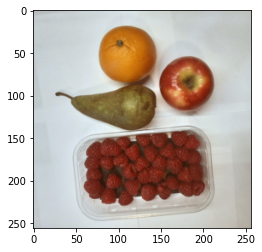

(None,
 (['pear', 'grape', 'strawberry'],
  ['A medium-sized pear (178 grams) provides the following nutrients: Calories: 101, Protein: 1 gram, Carbs: 27 grams, Fiber: 6 grams, Vitamin C: 12% of the Daily Value (DV)\nVitamin K: 6% of DV\nPotassium: 4% of the DV\nCopper: 16% of DV\nPears are a powerhouse fruit, packing fiber, vitamins, and beneficial plant compounds.\nThese nutrients are thought to fight inflammation, promote gut and heart health, protect against certain diseases, and even aid weight loss.\nJust be sure to eat the peel, as it harbors many of this fruit’s nutrients.',
   'Here are some of the major nutrients found in half of a medium-sized grapefruit: Calories: 52, Carbs: 13 grams, Protein: 1 gram, Fiber: 2 grams\nVitamin C: 64% of the recommended dietary intake (RDI)\nVitamin A: 28% of the RDI\nIt may reduce the risk of kidney stones\nGrapefruit has hydration benefits\nIt’s easy to add to your diet\nGrapefruit has weight loss benefits',
   'Strawberries mainly consist o

In [58]:
outputs = model(inf_images.to(device))

showim(inf_images[7]), infer_usecase(outputs[7].round())

# Transfer Learning (MobileNetV2)

By using transfer learning, we were able to use a model trained for a different task as a starting point for our classification task.

MobileNetV2 uses an inverted residual structure lightweight convolutions to filter features and reduces non-linearity which make it very fast. It has also proved to be a good model for object detection (Bogomasov and Conrad 2021)

We decided to use MobileNetV2 because it is a CNN designed to perform well on mobile devices (Pytorch Team 2022) (which is in line with the typical use case of our multi-label fruit classification). We modified its output layer by changing the number of output classes to 12 and including a sigmoid function.



Aplying the transforms again and normalizing with the required stats for MobileNet V2

In [39]:
mobmean = [0.485, 0.456, 0.406]
mobstd = [0.229, 0.224, 0.225]

#creating custom transforms on the train and test images
train_transform = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_transform_1 = transforms.Compose([transforms.Resize((256,256)),
                                        transforms.RandomHorizontalFlip(p=0.8),
                                        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.8),
                                        transforms.ColorJitter(brightness=(0.8, 1.5), contrast=(0.8,1.5)),
                                        transforms.RandomPerspective(distortion_scale=0.4, p=0.3, fill=(255,255,255)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((256,256)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


#calling the custom dataset class to create our train and test datasets with their labels and tranformations applied

#Train
train_dataset = CustomFruitsDataset(train_files, train_labels, train_transform)
train_dataset_1 = CustomFruitsDataset(train_files, train_labels, train_transform_1)

#Test
test_dataset = CustomFruitsDataset(test_files, test_labels, test_transform)

#Concatenating both training datasets
add_train_dataset = torch.utils.data.ConcatDataset([train_dataset, train_dataset_1])

Initialising the Data Loader for the Network

In [40]:
batch_size = 32
train_loader = DataLoader(add_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Modifying the architecture to change output classes and apply sigmoid activation.

In [41]:
class MobNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.model_fc = nn.Sequential(*(list(self.mobilenet.children())[:-1]))
        self.sigmoid = nn.Sigmoid()

        self.newfc = nn.Sequential(
              nn.Linear(in_features=81920, out_features=12, bias=True))

    def forward(self, x):
        x = self.model_fc(x)
        x = torch.flatten(x, 1)
        x = self.newfc(x)
        return self.sigmoid(x)  

Setting Hyperparameters

In [42]:
mobnet = MobNet().to(device)

learning_rate = 0.001
lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(mobnet.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Traing and Validation Loop

In [44]:
trn_losses, val_losses = [], [] 
trn_acc, val_acc = [], []
for i in tqdm(range(1, 17)):
    trn_l, trn_a = fit_model(i, mobnet, train_loader, phase= 'training')
    val_l, val_a = fit_model(i, mobnet, validation_loader, phase = 'validation')
    trn_losses.append(trn_l); trn_acc.append(trn_a)
    val_losses.append(val_l); val_acc.append(val_a)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1



0it [00:00, ?it/s]
1it [00:10, 10.53s/it]
2it [00:10,  4.57s/it]
3it [00:20,  6.77s/it]
4it [00:20,  4.25s/it]
5it [00:30,  6.17s/it]
6it [00:30,  4.20s/it]
7it [00:40,  5.96s/it]
8it [00:40,  4.18s/it]
9it [00:50,  5.85s/it]
10it [00:50,  4.16s/it]
11it [01:00,  5.80s/it]
12it [01:00,  4.15s/it]
13it [01:10,  5.84s/it]
14it [01:10,  4.19s/it]
15it [01:21,  6.11s/it]
16it [01:21,  4.39s/it]
17it [01:31,  6.21s/it]
18it [01:32,  4.46s/it]
19it [01:41,  5.97s/it]
20it [01:42,  4.37s/it]
21it [01:43,  4.94s/it]

training loss is 8.233334495907737
training accuracy is 0.6211061507936508
Epoch: 1




0it [00:00, ?it/s]
1it [00:09,  9.89s/it]
2it [00:10,  4.16s/it]
3it [00:13,  4.43s/it]
  6%|▋         | 1/16 [01:57<29:19, 117.27s/it]

validation loss is 18.300854365030926
validation accuracy is 0.6919367283950617
Epoch: 2



0it [00:00, ?it/s]
1it [00:10, 10.55s/it]
2it [00:10,  4.57s/it]
3it [00:21,  7.09s/it]
4it [00:21,  4.44s/it]
5it [00:31,  6.31s/it]
6it [00:31,  4.29s/it]
7it [00:41,  6.10s/it]
8it [00:41,  4.28s/it]
9it [00:51,  5.97s/it]
10it [00:51,  4.24s/it]
11it [01:01,  5.86s/it]
12it [01:01,  4.28s/it]
13it [01:11,  5.94s/it]
14it [01:12,  4.26s/it]
15it [01:21,  5.91s/it]
16it [01:22,  4.32s/it]
17it [01:32,  5.97s/it]
18it [01:32,  4.32s/it]
19it [01:42,  5.98s/it]
20it [01:42,  4.30s/it]
21it [01:44,  4.98s/it]

training loss is 1.9851103112811135
training accuracy is 0.6776537698412698
Epoch: 2




0it [00:00, ?it/s]
1it [00:10, 10.18s/it]
2it [00:10,  4.27s/it]
3it [00:13,  4.54s/it]
 12%|█▎        | 2/16 [03:55<27:30, 117.92s/it]

validation loss is 1.0250114003817241
validation accuracy is 0.7195216049382717
Epoch: 3



0it [00:00, ?it/s]
1it [00:10, 10.31s/it]
2it [00:10,  4.47s/it]
3it [00:20,  6.89s/it]
4it [00:20,  4.33s/it]
5it [00:30,  6.24s/it]
6it [00:30,  4.24s/it]
7it [00:40,  6.05s/it]
8it [00:41,  4.35s/it]
9it [00:50,  5.98s/it]
10it [00:51,  4.27s/it]
11it [01:00,  5.88s/it]
12it [01:01,  4.30s/it]
13it [01:10,  5.84s/it]
14it [01:11,  4.19s/it]
15it [01:20,  5.81s/it]
16it [01:21,  4.18s/it]
17it [01:30,  5.82s/it]
18it [01:31,  4.19s/it]
19it [01:40,  5.77s/it]
20it [01:41,  4.19s/it]
21it [01:42,  4.90s/it]

training loss is 1.4961018562316895
training accuracy is 0.6943700396825397
Epoch: 3




0it [00:00, ?it/s]
1it [00:10, 10.02s/it]
2it [00:10,  4.22s/it]
3it [00:13,  4.47s/it]
 19%|█▉        | 3/16 [05:52<25:24, 117.25s/it]

validation loss is 3.138434092203776
validation accuracy is 0.6936728395061729
Epoch: 4



0it [00:00, ?it/s]
1it [00:10, 10.09s/it]
2it [00:10,  4.37s/it]
3it [00:19,  6.72s/it]
4it [00:20,  4.22s/it]
5it [00:29,  6.15s/it]
6it [00:30,  4.19s/it]
7it [00:39,  5.85s/it]
8it [00:40,  4.23s/it]
9it [00:49,  5.67s/it]
10it [00:50,  4.23s/it]
11it [00:58,  5.63s/it]
12it [01:00,  4.28s/it]
13it [01:08,  5.56s/it]
14it [01:10,  4.30s/it]
15it [01:18,  5.61s/it]
16it [01:19,  4.24s/it]
17it [01:28,  5.67s/it]
18it [01:29,  4.30s/it]
19it [01:38,  5.61s/it]
20it [01:39,  4.25s/it]
21it [01:40,  4.80s/it]

training loss is 1.9956953553926378
training accuracy is 0.7143849206349208
Epoch: 4




0it [00:00, ?it/s]
1it [00:09,  9.86s/it]
2it [00:10,  4.14s/it]
3it [00:13,  4.42s/it]
 25%|██▌       | 4/16 [07:46<23:13, 116.11s/it]

validation loss is 0.5456981857617696
validation accuracy is 0.7524112654320989
Epoch: 5



0it [00:00, ?it/s]
1it [00:10, 10.29s/it]
2it [00:10,  4.46s/it]
3it [00:20,  6.71s/it]
4it [00:20,  4.22s/it]
5it [00:29,  6.06s/it]
6it [00:30,  4.14s/it]
7it [00:39,  5.93s/it]
8it [00:40,  4.16s/it]
9it [00:49,  5.86s/it]
10it [00:50,  4.17s/it]
11it [00:59,  5.89s/it]
12it [01:00,  4.21s/it]
13it [01:10,  5.92s/it]
14it [01:10,  4.25s/it]
15it [01:20,  5.98s/it]
16it [01:20,  4.29s/it]
17it [01:31,  6.04s/it]
18it [01:31,  4.34s/it]
19it [01:41,  5.95s/it]
20it [01:41,  4.27s/it]
21it [01:43,  4.91s/it]

training loss is 1.177294066974095
training accuracy is 0.7208581349206349
Epoch: 5




0it [00:00, ?it/s]
1it [00:10, 10.17s/it]
2it [00:10,  4.29s/it]
3it [00:13,  4.54s/it]
 31%|███▏      | 5/16 [09:43<21:20, 116.41s/it]

validation loss is 0.585824598868688
validation accuracy is 0.7666859567901234
Epoch: 6



0it [00:00, ?it/s]
1it [00:10, 10.67s/it]
2it [00:11,  4.61s/it]
3it [00:20,  7.01s/it]
4it [00:21,  4.39s/it]
5it [00:30,  6.27s/it]
6it [00:31,  4.36s/it]
7it [00:41,  6.08s/it]
8it [00:42,  4.42s/it]
9it [00:51,  5.95s/it]
10it [00:52,  4.39s/it]
11it [01:01,  5.85s/it]
12it [01:02,  4.36s/it]
13it [01:11,  5.70s/it]
14it [01:12,  4.40s/it]
15it [01:21,  5.68s/it]
16it [01:22,  4.36s/it]
17it [01:31,  5.76s/it]
18it [01:32,  4.26s/it]
19it [01:41,  5.66s/it]
20it [01:42,  4.26s/it]
21it [01:43,  4.93s/it]

training loss is 1.7893009299323672
training accuracy is 0.7404265873015873
Epoch: 6




0it [00:00, ?it/s]
1it [00:09,  9.83s/it]
2it [00:10,  4.22s/it]
3it [00:13,  4.41s/it]
 38%|███▊      | 6/16 [11:40<19:25, 116.58s/it]

validation loss is 1.0414933562278748
validation accuracy is 0.7414158950617283
Epoch: 7



0it [00:00, ?it/s]
1it [00:10, 10.08s/it]
2it [00:10,  4.37s/it]
3it [00:20,  6.80s/it]
4it [00:20,  4.36s/it]
5it [00:29,  6.07s/it]
6it [00:30,  4.28s/it]
7it [00:39,  5.75s/it]
8it [00:40,  4.26s/it]
9it [00:49,  5.72s/it]
10it [00:50,  4.25s/it]
11it [00:58,  5.57s/it]
12it [01:00,  4.32s/it]
13it [01:08,  5.56s/it]
14it [01:10,  4.30s/it]
15it [01:18,  5.54s/it]
16it [01:19,  4.26s/it]
17it [01:28,  5.43s/it]
18it [01:30,  4.41s/it]
19it [01:37,  5.41s/it]
20it [01:40,  4.45s/it]
21it [01:40,  4.79s/it]

training loss is 1.9998827803702581
training accuracy is 0.7359623015873016
Epoch: 7




0it [00:00, ?it/s]
1it [00:09,  9.75s/it]
2it [00:09,  4.11s/it]
3it [00:13,  4.36s/it]
 44%|████▍     | 7/16 [13:34<17:21, 115.70s/it]

validation loss is 0.5296454429626465
validation accuracy is 0.7119984567901234
Epoch: 8



0it [00:00, ?it/s]
1it [00:10, 10.21s/it]
2it [00:10,  4.43s/it]
3it [00:20,  6.70s/it]
4it [00:20,  4.26s/it]
5it [00:29,  6.11s/it]
6it [00:30,  4.16s/it]
7it [00:39,  5.93s/it]
8it [00:40,  4.16s/it]
9it [00:49,  5.86s/it]
10it [00:50,  4.16s/it]
11it [00:59,  5.77s/it]
12it [00:59,  4.13s/it]
13it [01:09,  5.75s/it]
14it [01:09,  4.12s/it]
15it [01:19,  5.73s/it]
16it [01:19,  4.12s/it]
17it [01:29,  5.75s/it]
18it [01:29,  4.14s/it]
19it [01:38,  5.64s/it]
20it [01:39,  4.05s/it]
21it [01:40,  4.79s/it]

training loss is 1.6368820241519384
training accuracy is 0.7447420634920635
Epoch: 8




0it [00:00, ?it/s]
1it [00:09,  9.69s/it]
2it [00:09,  4.07s/it]
3it [00:13,  4.35s/it]
 50%|█████     | 8/16 [15:28<15:20, 115.12s/it]

validation loss is 6.724072217941284
validation accuracy is 0.7110339506172839
Epoch: 9



0it [00:00, ?it/s]
1it [00:09,  9.90s/it]
2it [00:10,  4.30s/it]
3it [00:19,  6.71s/it]
4it [00:20,  4.21s/it]
5it [00:29,  6.00s/it]
6it [00:29,  4.15s/it]
7it [00:39,  5.80s/it]
8it [00:39,  4.08s/it]
9it [00:49,  5.79s/it]
10it [00:49,  4.11s/it]
11it [00:58,  5.64s/it]
12it [00:58,  4.04s/it]
13it [01:08,  5.69s/it]
14it [01:08,  4.09s/it]
15it [01:18,  5.68s/it]
16it [01:18,  4.08s/it]
17it [01:27,  5.65s/it]
18it [01:28,  4.06s/it]
19it [01:37,  5.64s/it]
20it [01:37,  4.05s/it]
21it [01:39,  4.73s/it]

training loss is 1.3695650469689142
training accuracy is 0.7563492063492062
Epoch: 9




0it [00:00, ?it/s]
1it [00:09,  9.81s/it]
2it [00:09,  4.14s/it]
3it [00:13,  4.39s/it]
 56%|█████▋    | 9/16 [17:20<13:20, 114.39s/it]

validation loss is 0.6117790341377258
validation accuracy is 0.7645640432098766
Epoch: 10



0it [00:00, ?it/s]
1it [00:10, 10.13s/it]
2it [00:10,  4.39s/it]
3it [00:19,  6.65s/it]
4it [00:20,  4.17s/it]
5it [00:29,  5.89s/it]
6it [00:30,  4.23s/it]
7it [00:38,  5.72s/it]
8it [00:39,  4.21s/it]
9it [00:48,  5.69s/it]
10it [00:49,  4.24s/it]
11it [00:58,  5.59s/it]
12it [00:59,  4.27s/it]
13it [01:08,  5.56s/it]
14it [01:09,  4.27s/it]
15it [01:18,  5.55s/it]
16it [01:19,  4.21s/it]
17it [01:28,  5.63s/it]
18it [01:29,  4.20s/it]
19it [01:38,  5.65s/it]
20it [01:38,  4.13s/it]
21it [01:40,  4.77s/it]

training loss is 1.5088082637105669
training accuracy is 0.7601438492063493
Epoch: 10




0it [00:00, ?it/s]
1it [00:09,  9.51s/it]
2it [00:09,  4.04s/it]
3it [00:12,  4.27s/it]
 62%|██████▎   | 10/16 [19:13<11:23, 114.00s/it]

validation loss is 4.817196846008301
validation accuracy is 0.75
Epoch: 11



0it [00:00, ?it/s]
1it [00:09,  9.90s/it]
2it [00:10,  4.32s/it]
3it [00:19,  6.65s/it]
4it [00:20,  4.17s/it]
5it [00:29,  5.97s/it]
6it [00:29,  4.08s/it]
7it [00:38,  5.70s/it]
8it [00:39,  4.11s/it]
9it [00:48,  5.67s/it]
10it [00:49,  4.14s/it]
11it [00:58,  5.65s/it]
12it [00:59,  4.21s/it]
13it [01:08,  5.62s/it]
14it [01:09,  4.21s/it]
15it [01:17,  5.63s/it]
16it [01:19,  4.25s/it]
17it [01:27,  5.47s/it]
18it [01:28,  4.27s/it]
19it [01:36,  5.42s/it]
20it [01:38,  4.26s/it]
21it [01:39,  4.73s/it]

training loss is 1.3236231250422341
training accuracy is 0.7692212301587302
Epoch: 11




0it [00:00, ?it/s]
1it [00:09,  9.53s/it]
2it [00:09,  4.07s/it]
3it [00:12,  4.27s/it]
 69%|██████▉   | 11/16 [21:06<09:27, 113.49s/it]

validation loss is 0.641419529914856
validation accuracy is 0.7705439814814815
Epoch: 12



0it [00:00, ?it/s]
1it [00:10, 10.01s/it]
2it [00:10,  4.35s/it]
3it [00:19,  6.64s/it]
4it [00:20,  4.16s/it]
5it [00:29,  5.98s/it]
6it [00:29,  4.07s/it]
7it [00:39,  5.85s/it]
8it [00:39,  4.10s/it]
9it [00:49,  5.81s/it]
10it [00:49,  4.13s/it]
11it [00:59,  5.78s/it]
12it [00:59,  4.14s/it]
13it [01:08,  5.72s/it]
14it [01:09,  4.10s/it]
15it [01:18,  5.69s/it]
16it [01:18,  4.09s/it]
17it [01:28,  5.64s/it]
18it [01:28,  4.06s/it]
19it [01:37,  5.59s/it]
20it [01:38,  4.02s/it]
21it [01:39,  4.74s/it]

training loss is 1.59902746904464
training accuracy is 0.7686507936507936
Epoch: 12




0it [00:00, ?it/s]
1it [00:09,  9.72s/it]
2it [00:09,  4.10s/it]
3it [00:13,  4.34s/it]
 75%|███████▌  | 12/16 [22:59<07:33, 113.28s/it]

validation loss is 5.010720411936442
validation accuracy is 0.7491319444444445
Epoch: 13



0it [00:00, ?it/s]
1it [00:10, 10.15s/it]
2it [00:10,  4.40s/it]
3it [00:19,  6.55s/it]
4it [00:20,  4.11s/it]
5it [00:29,  6.05s/it]
6it [00:29,  4.12s/it]
7it [00:39,  5.91s/it]
8it [00:39,  4.15s/it]
9it [00:48,  5.69s/it]
10it [00:49,  4.05s/it]
11it [00:58,  5.70s/it]
12it [00:59,  4.08s/it]
13it [01:08,  5.74s/it]
14it [01:09,  4.12s/it]
15it [01:18,  5.71s/it]
16it [01:18,  4.11s/it]
17it [01:28,  5.71s/it]
18it [01:28,  4.11s/it]
19it [01:37,  5.64s/it]
20it [01:38,  4.05s/it]
21it [01:39,  4.75s/it]

training loss is 1.4517923139390492
training accuracy is 0.7718501984126983
Epoch: 13




0it [00:00, ?it/s]
1it [00:09,  9.81s/it]
2it [00:09,  4.12s/it]
3it [00:13,  4.37s/it]
 81%|████████▏ | 13/16 [24:52<05:39, 113.23s/it]

validation loss is 8.578120867411295
validation accuracy is 0.7118055555555555
Epoch: 14



0it [00:00, ?it/s]
1it [00:10, 10.22s/it]
2it [00:10,  4.42s/it]
3it [00:20,  6.81s/it]
4it [00:20,  4.28s/it]
5it [00:30,  6.19s/it]
6it [00:30,  4.21s/it]
7it [00:40,  5.99s/it]
8it [00:40,  4.20s/it]
9it [00:50,  5.83s/it]
10it [00:50,  4.15s/it]
11it [00:59,  5.76s/it]
12it [01:00,  4.13s/it]
13it [01:09,  5.64s/it]
14it [01:09,  4.05s/it]
15it [01:19,  5.69s/it]
16it [01:19,  4.09s/it]
17it [01:29,  5.71s/it]
18it [01:29,  4.10s/it]
19it [01:38,  5.69s/it]
20it [01:39,  4.09s/it]
21it [01:40,  4.79s/it]

training loss is 1.7073114599500383
training accuracy is 0.778968253968254
Epoch: 14




0it [00:00, ?it/s]
1it [00:09,  9.92s/it]
2it [00:10,  4.18s/it]
3it [00:13,  4.43s/it]
 88%|████████▊ | 14/16 [26:46<03:46, 113.48s/it]

validation loss is 2.559630592664083
validation accuracy is 0.7255979938271605
Epoch: 15



0it [00:00, ?it/s]
1it [00:09,  9.85s/it]
2it [00:10,  4.33s/it]
3it [00:19,  6.61s/it]
4it [00:20,  4.32s/it]
5it [00:29,  6.13s/it]
6it [00:30,  4.31s/it]
7it [00:39,  5.96s/it]
8it [00:40,  4.30s/it]
9it [00:49,  5.77s/it]
10it [00:50,  4.13s/it]
11it [00:59,  5.79s/it]
12it [01:00,  4.14s/it]
13it [01:09,  5.81s/it]
14it [01:10,  4.17s/it]
15it [01:19,  5.80s/it]
16it [01:20,  4.16s/it]
17it [01:29,  5.81s/it]
18it [01:30,  4.18s/it]
19it [01:39,  5.71s/it]
20it [01:39,  4.15s/it]
21it [01:41,  4.83s/it]

training loss is 1.3472858837672643
training accuracy is 0.7947916666666667
Epoch: 15




0it [00:00, ?it/s]
1it [00:09,  9.59s/it]
2it [00:09,  4.06s/it]
3it [00:12,  4.30s/it]
 94%|█████████▍| 15/16 [28:40<01:53, 113.79s/it]

validation loss is 4.938799937566121
validation accuracy is 0.7434413580246914
Epoch: 16



0it [00:00, ?it/s]
1it [00:11, 11.34s/it]
2it [00:11,  4.89s/it]
3it [00:21,  7.01s/it]
4it [00:21,  4.40s/it]
5it [00:30,  6.13s/it]
6it [00:31,  4.17s/it]
7it [00:40,  5.93s/it]
8it [00:41,  4.16s/it]
9it [00:50,  5.82s/it]
10it [00:50,  4.13s/it]
11it [01:00,  5.85s/it]
12it [01:01,  4.19s/it]
13it [01:10,  5.84s/it]
14it [01:11,  4.19s/it]
15it [01:20,  5.83s/it]
16it [01:21,  4.19s/it]
17it [01:30,  5.79s/it]
18it [01:30,  4.16s/it]
19it [01:39,  5.60s/it]
20it [01:40,  4.03s/it]
21it [01:41,  4.85s/it]

training loss is 1.3384866941542852
training accuracy is 0.8109623015873016
Epoch: 16




0it [00:00, ?it/s]
1it [00:09,  9.79s/it]
2it [00:10,  4.20s/it]
3it [00:13,  4.39s/it]
100%|██████████| 16/16 [30:36<00:00, 114.75s/it]

validation loss is 0.9511874914169312
validation accuracy is 0.7763310185185185


Loss and Accuracy graphs

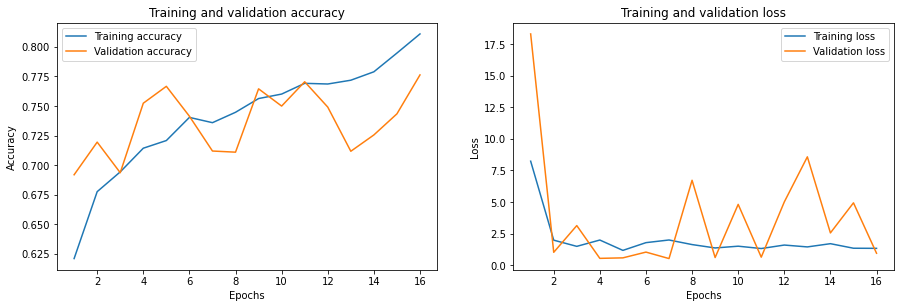

In [45]:
graphs(trn_acc, val_acc, trn_losses, val_losses)

Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


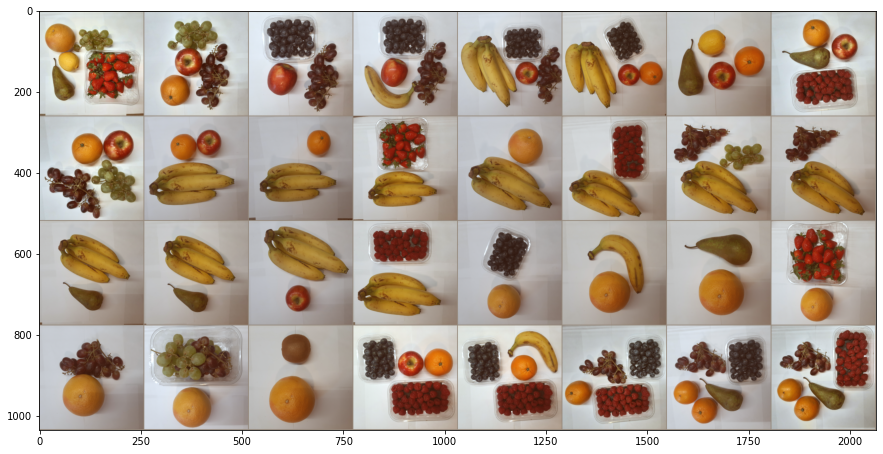

In [50]:
#test_batch = iter(validation_loader)
#images, labels = test_batch.next()
inf_images, inf_labels = next(test_batch)

plt.figure(figsize=(15, 10))
showim(torchvision.utils.make_grid(inf_images))

In [51]:
infer(test_model = mobnet, img=inf_images)

[['red_grape', 'lemon'],
 ['red_grape'],
 ['orange', 'blueberry', 'red_grape'],
 ['banana', 'orange', 'apple', 'blueberry', 'red_grape'],
 ['blueberry', 'red_grape', 'green_grape'],
 ['banana', 'orange', 'apple', 'blueberry', 'red_grape', 'lemon'],
 ['banana', 'orange', 'apple', 'lemon'],
 ['strawberry'],
 ['banana', 'blueberry'],
 ['banana', 'grape'],
 ['banana'],
 [],
 ['banana', 'grape'],
 ['red_grape'],
 ['raspberry'],
 [],
 ['banana'],
 ['banana'],
 ['banana'],
 ['banana', 'red_grape'],
 ['banana', 'orange', 'blueberry'],
 ['banana', 'orange'],
 [],
 ['banana'],
 [],
 ['blueberry'],
 [],
 ['blueberry', 'strawberry', 'raspberry'],
 ['blueberry', 'strawberry', 'raspberry'],
 ['orange', 'blueberry', 'strawberry', 'raspberry', 'red_grape'],
 ['orange', 'blueberry'],
 ['orange', 'kiwi', 'blueberry', 'red_grape']]

Inference with the nutrition facts and Health tips

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


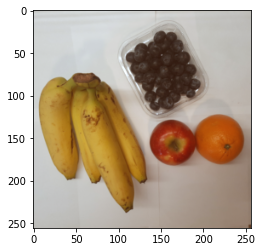

(None,
 (['banana', 'orange', 'apple', 'blueberry', 'red_grape', 'lemon'],
  ['Bananas are a healthy source of fiber, potassium, vitamin B6, vitamin C, and various antioxidants and phytonutrients.\n1 medium-sized banana(100g) contains: Calories: 89, Water: 75%, Protein: 1.1 grams, Carbs: 22.8 grams, Sugar: 12.2 grams, Fiber: 2.6 grams, Fat: 0.3 grams\nBananas are a rich source of carbohydrate.\nBananas are a good source of several vitamins and minerals, especially potassium, vitamin B6, and vitamin C\nBananas are a good source of potassium. A diet high in potassium can lower blood pressure in people with elevated levels and benefits heart health.\nBananas are high in potassium, a mineral that promotes heart health and normal blood pressure. One medium-sized banana contains around 0.4 grams of this mineral.\npeople with diabetes should avoid eating a lot of well-ripened bananas. It’s always best to monitor blood sugar levels carefully after consuming high amounts of of sugar and carbs.\

In [60]:
outputs = mobnet(inf_images.to(device))

showim(inf_images[5]), infer_usecase(outputs[5].round())

# Conclusion

We successfully trained two deep learning Convolution Neural Network models on our multi-label image fruits dataset. Our custom architecture after 16 epochs produced 90% accuracy on the training data and 77% on the test data. We realised that with larger epochs the model starts to overfit seriously on the training data and gets worse at fitting the validation data. 

For the pretrained MobilenetV2 model, after 16 epochs the training accuracy was 81% and 77% on the validation data. With more epochs, this model would also achieve a similar training accuracy score as the custom model and start to overfit on the validation data.

Even after augmentation to increase the training set and several parameter tunings, the best validation accuracy did not go more than 80%. The dataset being very small is the main reason for the model overfitting and the reason for the significant accuracy difference of the training and validation data. Both models can be improved by adding more data and training for longer epochs.

# References


Ariane Lang, M. G., 2022. *Top 16 Health Benefits of Eating Grapes* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/benefits-of-grapes [Accessed 11 May 2022].

Arnarson, A., 2019. *Apples 101: Nutrition Facts and Health Benefits* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/foods/apples [Accessed 11 May 2022].

Arnarson, A., 2019. *Bananas 101: Nutrition Facts and Health Benefits* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/foods/bananas [Accessed 11 May 2022].

Bjarnadottir, A., 2019. *Lemons 101: Nutrition Facts and Health Benefits* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/foods/lemons#:~:text=Lemons%20contain%20very%20little%20fat,provides%20only%20about%2020%20calories. [Accessed 11 May 2022].

Bjarnadottir, A., 2019. *Strawberries 101: Nutrition Facts and Health Benefits* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/foods/strawberries [Accessed 11 May 2022].

Boeing, H., Bechthold, A., Bub, A., Ellinger, S., Haller, D., Kroke, A., Leschik-Bonnet, E., Müller, M. J., Oberritter, H., Schulze, M., Stehle, P. and Watzl, B., 2012. Critical review: vegetables and fruit in the prevention of chronic diseases. *European Journal of Nutrition* [online], 51 (6), 637-663.

Bogomasov, K. and Conrad, S., 2021. Efficient Fruit and Vegetable Classification and Counting for Retail Applications Using Deep Learning. *2021 The 5th International Conference on Advances in Artificial Intelligence (ICAAI)*, Virtual Event, United Kingdom. Association for Computing Machinery. 65–71. Available from: https://doi.org/10.1145/3505711.3505720 [Accessed 18 May 2022]

Elliott, B., 2022. *10 Health Benefits of Grapefruit* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/10-benefits-of-grapefruit [Accessed 11 May 2022].

Groves, M., 2018. *Red Raspberries: Nutrition Facts, Benefits and More* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/raspberry-nutrition [Accessed 11 May 2022].

Jillian Kubala, A. A., 2021. *Oranges 101: Health Benefits and Nutrition Facts* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/oranges [Accessed 11 May 2022].

Kubala, J., 2022. *Kiwi Benefits: Heart Health, Digestion, and More* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/kiwi-benefits [Accessed 11 May 2022].

Murphy, J. H., 2016. An Overview of Convolutional Neural Network Architectures for Deep Learning. Plymouth: Microway, Inc.


Palsdottir, H., 2019. *Blueberries 101: Nutrition Facts and Health Benefits* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/foods/blueberries [Accessed 11 May 2022].

Pytorch, 2022a. *Illustration of transforms - Torchvision 0.12 documentation* [online]. Carlifonia: Pytorch. Available from: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py [Accessed 18 May 2022].

Pytorch, 2022b.* Optimizing Model Parameters — PyTorch Tutorials 1.11.0+cu102 documentation* [online]. Pytorch. Available from: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html [Accessed 18 May 2022].

Sahoo, D., Hao, W., Ke, S., Wu, X., Le, H., Achananuparp, P., Lim, E.-P. and Hoi, S. C. H., 2019. FoodAI: Food Image Recognition via Deep Learning for Smart Food Logging. 2260-2268. Available from: https://doi.org/10.1145/3292500.3330734 [Accessed 11 May 2022].

Smith, L., 2018. A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay. *Cornell University, Machine Learning* [online].

Pytorch Team, 2022. MobileNet v2 [online]. Carlifonia: Pytorch. Available from: https://pytorch.org/hub/pytorch_vision_mobilenet_v2/ [Accessed 18 May 2022].

Volpe, S. L., 2019. Fruit and Vegetable Intake and Prevention of Chronic Disease. ACSM's Health & Fitness Journal [online], 23 (3).

Wartenberg, L., 2019. *9 Health and Nutrition Benefits of Pears* [online]. San Francisco: Healthline. Available from: https://www.healthline.com/nutrition/benefits-of-pears [Accessed 11 May 2022].

